# Speech Emotion recognition detector

### I. Setup prerequisite

In [1]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

#Install kaggle so we can load the data directly
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00


In [2]:
#Mount google drive, so we can fetch the kaggle.json from our drive into colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Setup kaggle directory
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab_Notebooks/kaggle'

In [ ]:
#download the RAVDESS, TESS, SAVEE dataset
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee

ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)
User cancelled operation
surrey-audiovisual-expressed-emotion-savee.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
#Import libraries
import os
import sys
import time

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from codecarbon import EmissionsTracker

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout

#
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import zipfile

# Define the path to your zip file
dest = '/content/drive/MyDrive/Colab_Notebooks/kaggle'  # Replace 'your_file.zip' with your file's name

# Get a list of all files in the current directory
file_list = os.listdir('/content')

# Iterate over each file in the directory
for file_name in file_list:
    # Check if the file is a zip file
    if file_name.endswith('.zip'):
        # Extract the contents of the zip file
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall(dest)
        print(f"Extracted {file_name} successfully.")

In [10]:
Ravdess = "/content/drive/MyDrive/Colab_Notebooks/kaggle/audio_speech_actors_01-24/"
Tess = "/content/drive/MyDrive/Colab_Notebooks/kaggle/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/drive/MyDrive/Colab_Notebooks/kaggle/ALL/"

## II. Data preprocessing

#### 1. Create dataframes from the dataset

In [11]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Change integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

Ravdess_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
1,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
2,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
3,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
4,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...


In [12]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

Tess_df.head()

,Emotions,Path
0,fear,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
1,fear,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
2,fear,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
3,fear,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
4,fear,/content/drive/MyDrive/Colab_Notebooks/kaggle/...


In [13]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

Savee_df.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
1,angry,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
2,angry,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
3,angry,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
4,angry,/content/drive/MyDrive/Colab_Notebooks/kaggle/...


I will aggregated 3 dataframes into one and export it into a csv file

In [14]:
aggregated_data = pd.concat([Ravdess_df, Tess_df, Savee_df], axis = 0)

# Shuffle the dataframe using the sample method
aggregated_data = aggregated_data.sample(frac=1).reset_index(drop=True)
aggregated_data.Emotions.value_counts()

neutral     808
sad         652
angry       652
disgust     652
fear        652
happy       652
surprise    652
Name: Emotions, dtype: int64

In [15]:
#Drop random 40% of dataset with emotion in (sad, angry, fear, disgust) so that the dataset would not be to skew toward the emotion
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'sad'].sample(frac=0.6).index)
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'angry'].sample(frac=0.6).index)
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'fear'].sample(frac=0.6).index)
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'disgust'].sample(frac=0.6).index)

aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'happy'].sample(frac=0.25).index)
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'surprise'].sample(frac=0.25).index)

# Merge rows where Emotions is "sad" and "angry", "fear", "disgust" and replace them with   "unpleasant"
aggregated_data['Emotions'] = aggregated_data['Emotions'].replace(['sad', 'angry', 'fear', 'disgust'], 'unpleasant')
aggregated_data['Emotions'] = aggregated_data['Emotions'].replace(['happy', 'surprise'], 'pleasant')



aggregated_data.to_csv("data_path.csv",index=False)
aggregated_data.head()

,Emotions,Path
0,unpleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
4,unpleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
5,unpleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
9,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...
10,unpleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...


In [16]:
aggregated_data.Emotions.value_counts()

unpleasant    1044
pleasant       978
neutral        808
Name: Emotions, dtype: int64

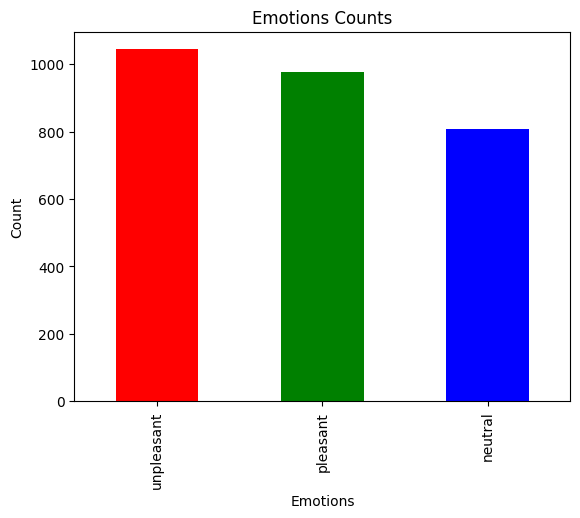

In [17]:
# Calculate the count of each category
category_counts = aggregated_data['Emotions'].value_counts()

# Plot a bar chart
category_counts.plot(kind='bar', color = ['red', 'green', 'blue'])

# Add labels and title
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotions Counts')

# Display the chart
plt.show()

#### 2. Data Exploration
In this section, visualizations of waveforms and spectrograms were generated for the emotions data. Additionally, various audio transformations, such as noise addition, time stretching, and pitch shifting, were applied to explore and highlight different properties of the audio data. These visualizations and transformations offer valuable insights into the characteristics and variations present in the audio samples.

In [18]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def noise(data):
    noise_amp = 0.5*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

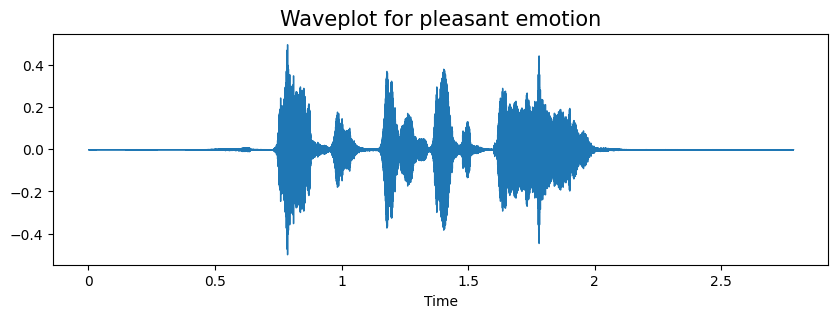

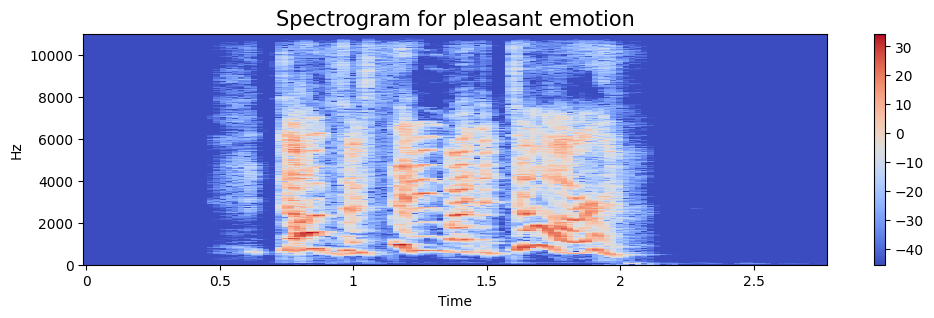

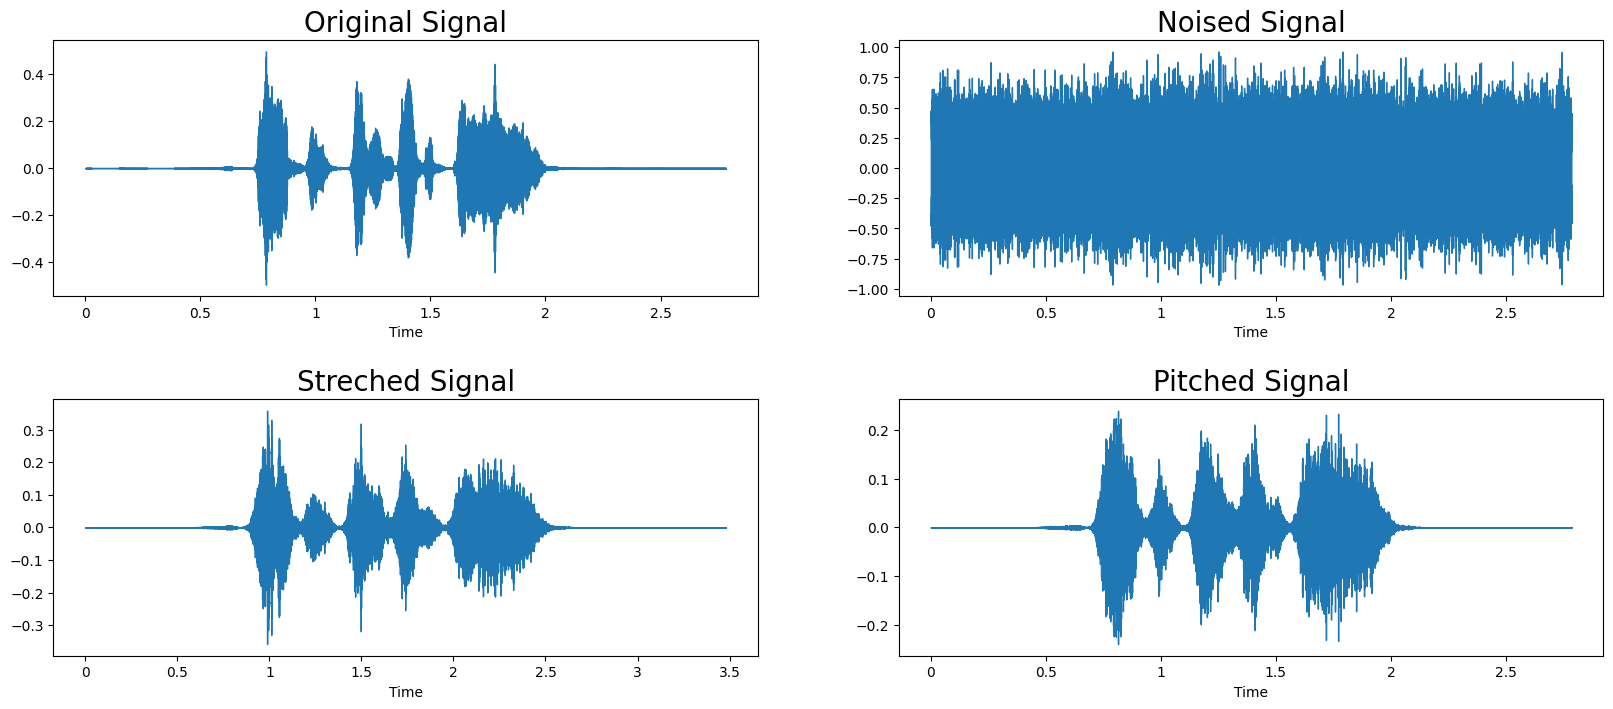

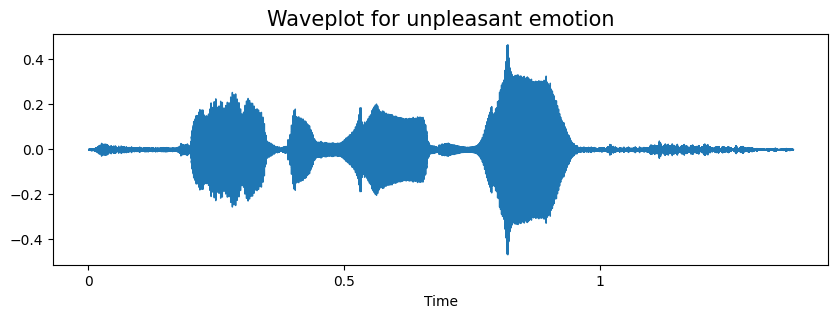

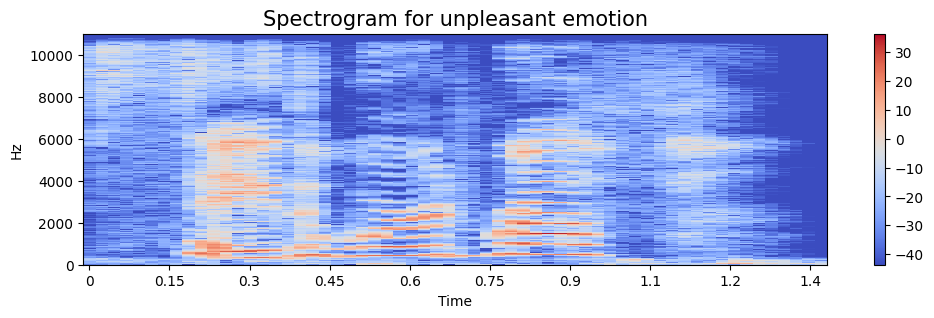

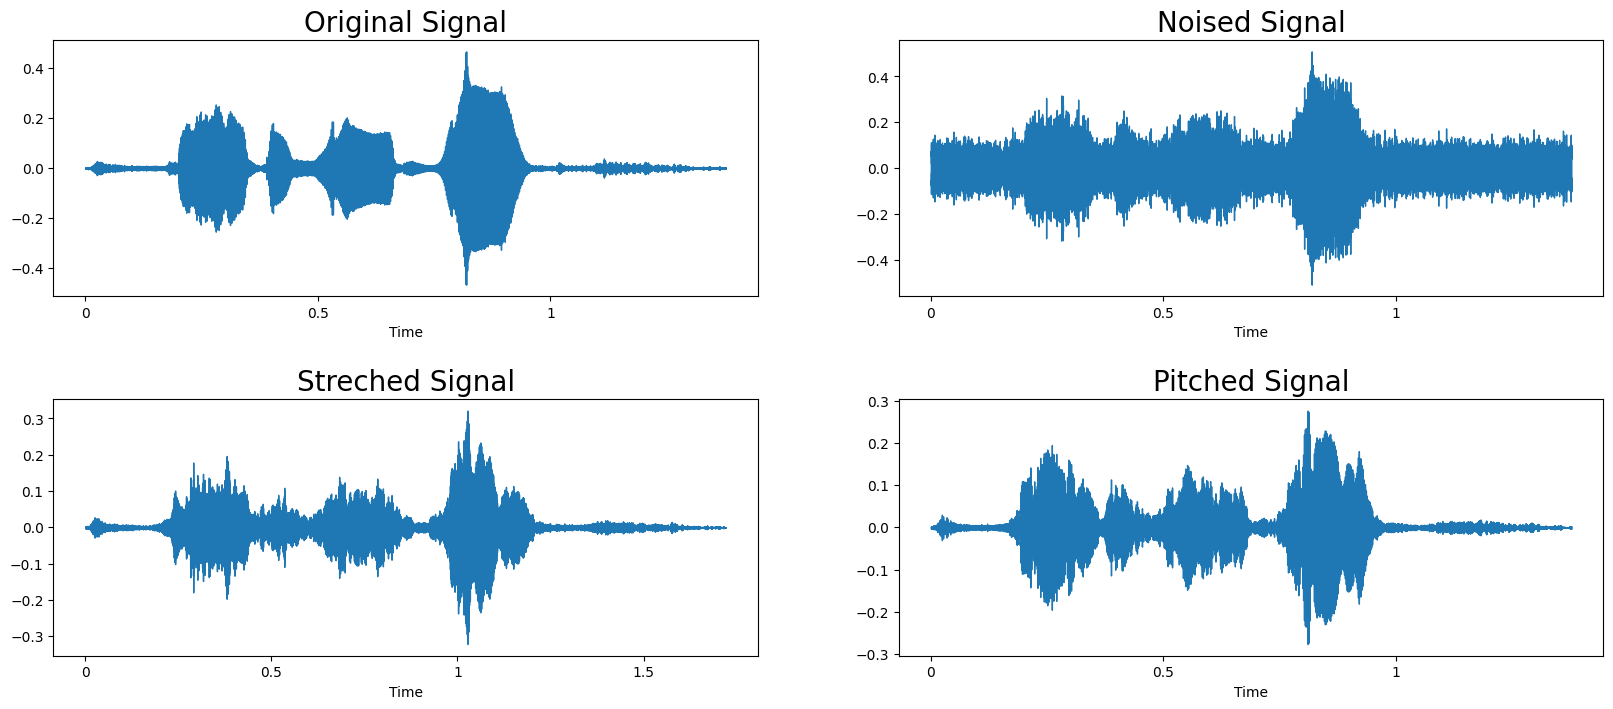

In [ ]:
#Try to display different emotion data in waveform and spectroram. Also trying to play the audio
emotions = ['pleasant', 'unpleasant']
data_list =[]
for emotion in emotions:
    path = np.array(aggregated_data.Path[aggregated_data.Emotions == emotion])[0]
    data, sample_rate = librosa.load(path)
    data = librosa.resample(data, orig_sr=sample_rate, target_sr=16000)
    noised_data = noise(data)
    data_list.append(data)

    create_waveplot(data, sample_rate, emotion)
    create_spectrogram(data, sample_rate, emotion)
    fig, axs = plt.subplots(2, 2, figsize=(20,8))
    plt.subplots_adjust(hspace=0.4)

    axs[0, 0].set_title('Original Signal', size=20)
    librosa.display.waveshow(y=data, sr=sample_rate, ax=axs[0, 0])

    axs[0, 1].set_title('Noised Signal', size=20)
    noise_data = noise(data)
    librosa.display.waveshow(y=noise_data, sr=sample_rate, ax=axs[0, 1])

    axs[1, 0].set_title('Streched Signal', size=20)
    stretch_data = stretch(data)
    librosa.display.waveshow(y=stretch_data, sr=sample_rate, ax=axs[1, 0])

    axs[1, 1].set_title('Pitched Signal', size=20)
    pitch_data = pitch(data, sample_rate)
    librosa.display.waveshow(y=pitch_data, sr=sample_rate, ax=axs[1, 1])

    plt.show()


In [ ]:
Audio(data=data_list[1], rate=16000)

#### 3. Data pre-processing
Emotion Label Encoding: The emotion labels are encoded to facilitate model training. This encoding step assigns numerical values to each unique emotion label.

- Feature Extraction using MFCC: The audio data is transformed into Mel Frequency Cepstral Coefficients (MFCC) features. MFCC is a commonly used feature representation for speech and audio processing tasks.

- Data Augmentation with Audio Transformations: The audio data is augmented by applying various audio transformations such as noise addition, time stretching, and pitch *shifting*. This augmentation technique increases the diversity of the training data and helps the model generalize better.

- Data Storage in CSV: The preprocessed data, including the encoded emotion labels and extracted MFCC features, is stored in a CSV file for easy access and further analysis.

- Data Split into Training, Validation, and Testing Sets: The preprocessed data is split into training, validation, and testing sets. This division allows for model training using the training set, hyperparameter tuning using the validation set, and final evaluation using the testing set.

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the emotions column
aggregated_data['ecoded_emotions'] = label_encoder.fit_transform(aggregated_data['Emotions'])

In [ ]:
aggregated_data

,Emotions,Path,ecoded_emotions
1,unpleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,2
3,pleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,1
4,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,0
7,unpleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,2
8,unpleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,2
...,...,...,...
4715,unpleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,2
4716,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,0
4717,pleasant,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,1
4718,neutral,/content/drive/MyDrive/Colab_Notebooks/kaggle/...,0


In [20]:
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_RATE = 22050
DOWN_SAMPLE_RATE = 16000
SAMPLE_NUM = aggregated_data.shape[0]

data = {
        "labels": [],
        "features": []
    }

def extract_features(data, sample_rate):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    feature = mfcc.T
    return feature

for i in range(SAMPLE_NUM):
    for j in range(2):
        data['labels'].append(aggregated_data.iloc[i,2])
    signal, sample_rate = librosa.load(aggregated_data.iloc[i,1], sr=SAMPLE_RATE)

    # Cropping & Resampling
    start_time = 0.4  # Start time in seconds
    end_time = 1.9  # End time in seconds
    start_frame = int(start_time * sample_rate)
    end_frame = int(end_time * sample_rate)
    signal = signal[start_frame:end_frame]
    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=DOWN_SAMPLE_RATE)

    # Add noise
    signal = noise(signal)
    res1 = extract_features(signal, DOWN_SAMPLE_RATE)
    data["features"].append(np.array(res1))

    # Stretch and shift pitch
    new_data = stretch(signal)[:24000]
    data_stretch_pitch = pitch(new_data, DOWN_SAMPLE_RATE)
    res2 = extract_features(data_stretch_pitch, DOWN_SAMPLE_RATE)
    data["features"].append(np.array(res2))

    if i % 100 == 0:
        print(f'Processing Data: {i}/{SAMPLE_NUM}')

Processing Data: 0/2830
Processing Data: 100/2830
Processing Data: 200/2830
Processing Data: 300/2830
Processing Data: 400/2830
Processing Data: 500/2830
Processing Data: 600/2830
Processing Data: 700/2830
Processing Data: 800/2830
Processing Data: 900/2830
Processing Data: 1000/2830
Processing Data: 1100/2830
Processing Data: 1200/2830
Processing Data: 1300/2830
Processing Data: 1400/2830
Processing Data: 1500/2830
Processing Data: 1600/2830
Processing Data: 1700/2830
Processing Data: 1800/2830
Processing Data: 1900/2830
Processing Data: 2000/2830
Processing Data: 2100/2830
Processing Data: 2200/2830
Processing Data: 2300/2830
Processing Data: 2400/2830
Processing Data: 2500/2830
Processing Data: 2600/2830
Processing Data: 2700/2830
Processing Data: 2800/2830


In [24]:
features = pd.DataFrame({'features': data['features'], 'labels': data['labels']})
features.to_csv('/content/drive/MyDrive/Colab_Notebooks/storage/features.csv', index=False)

In [23]:
features

,features,labels
0,[[-3.67791266e+02 8.60569170e+01 2.18111566e...,2
1,[[-3.67185540e+02 8.73269317e+01 1.98504753e...,2
2,[[-6.38241676e+02 -2.62746259e+00 8.30356956e...,2
3,[[-6.40107985e+02 -5.85384757e-01 6.28286722e...,2
4,[[-1.45567547e+02 7.84060184e+00 1.07605766e...,2
...,...,...
5655,[[-2.27959498e+02 4.47934108e+00 -2.14589349e...,2
5656,[[-6.14834396e+01 4.06849582e+00 5.01267983e...,2
5657,[[-6.33266312e+01 5.67537558e+00 2.82936268e...,2
5658,[[-1.74108599e+02 -6.10801582e+00 2.58579034e...,2


In [25]:
X = np.asarray(features['features'])
y = np.asarray(features["labels"])

# Pad Features to make them of equal length
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

print(f'Training Data:{X_train.shape} with label {y_train.shape}')
print(f'Validate Data:{X_validation.shape} with label {y_validation.shape}')
print(f' Testing Data:{X_test.shape} with label {y_test.shape}')

Training Data:(4075, 47, 13) with label (4075,)
Validate Data:(1019, 47, 13) with label (1019,)
 Testing Data:(566, 47, 13) with label (566,)


### III. LSTM model training and validation


In [30]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))

    return model

# Create network
input_shape = (47,13)
model = build_model(input_shape)

# Compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 47, 128)           72704     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 126532 (494.27 KB)
Trainable params: 126532 (494.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
EPOCHS = 20
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=EPOCHS)

Epoch 1/20
128/128 [==============================] - 21s 116ms/step - loss: 1.0031 - accuracy: 0.4960 - val_loss: 0.7892 - val_accuracy: 0.6124
Epoch 2/20
128/128 [==============================] - 13s 101ms/step - loss: 0.8056 - accuracy: 0.6226 - val_loss: 0.7090 - val_accuracy: 0.6781
Epoch 3/20
128/128 [==============================] - 14s 109ms/step - loss: 0.7199 - accuracy: 0.6694 - val_loss: 0.6770 - val_accuracy: 0.6909
Epoch 4/20
128/128 [==============================] - 15s 116ms/step - loss: 0.6549 - accuracy: 0.6964 - val_loss: 0.6312 - val_accuracy: 0.7046
Epoch 5/20
128/128 [==============================] - 15s 117ms/step - loss: 0.5861 - accuracy: 0.7382 - val_loss: 0.6071 - val_accuracy: 0.7056
Epoch 6/20
128/128 [==============================] - 15s 116ms/step - loss: 0.5471 - accuracy: 0.7529 - val_loss: 0.5990 - val_accuracy: 0.7478
Epoch 7/20
128/128 [==============================] - 15s 115ms/step - loss: 0.5073 - accuracy: 0.7590 - val_loss: 0.6135 - val_ac

In [32]:
output_dir = '/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save('/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/Speech-Emotion-Recognition-Model.h5')
print('Save the Tensorflow model!')

Save the Tensorflow model!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 3.1 Model evaluation

In [33]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/Speech-Emotion-Recognition-Model.h5')

Test Accuracy:  74.9116599559784 %


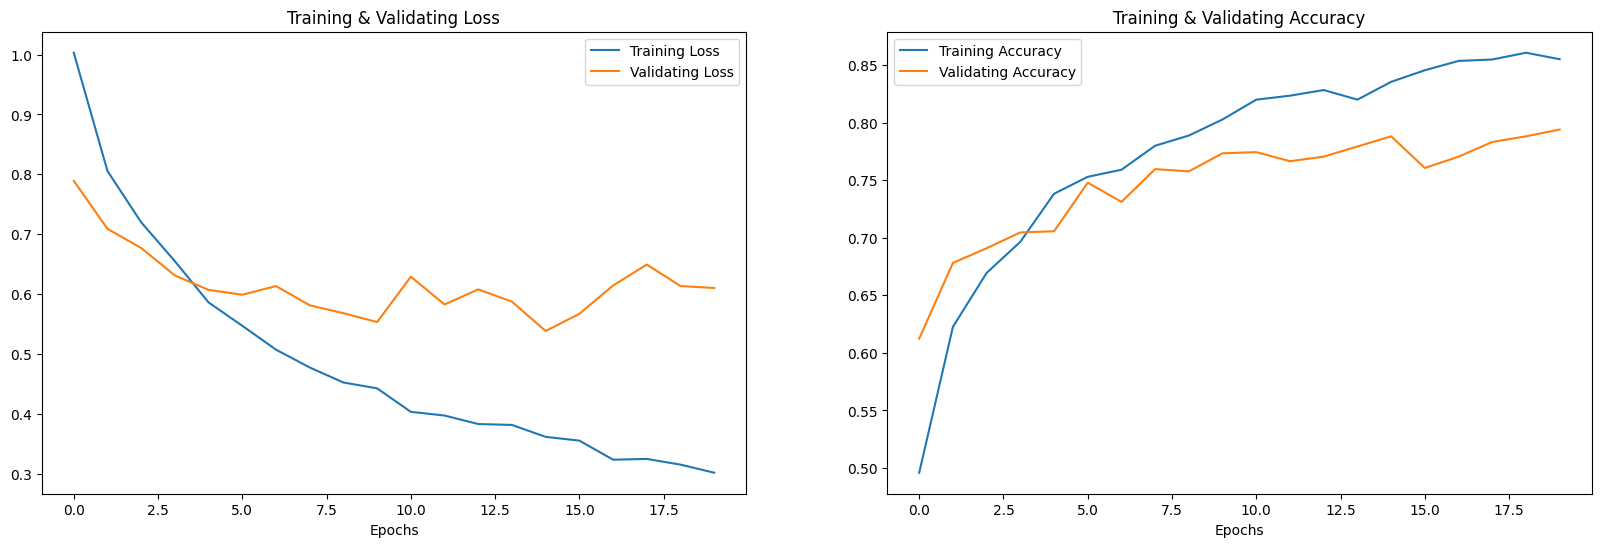

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ", test_acc*100 , "%")


epochs = [i for i in range(20)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, val_acc, label='Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

18/18 [==============================] - 1s 77ms/step
              precision    recall  f1-score   support

  unpleasant       0.77      0.83      0.80       173
   pleaseant       0.77      0.71      0.74       183
     neutral       0.71      0.71      0.71       210

    accuracy                           0.75       566
   macro avg       0.75      0.75      0.75       566
weighted avg       0.75      0.75      0.75       566



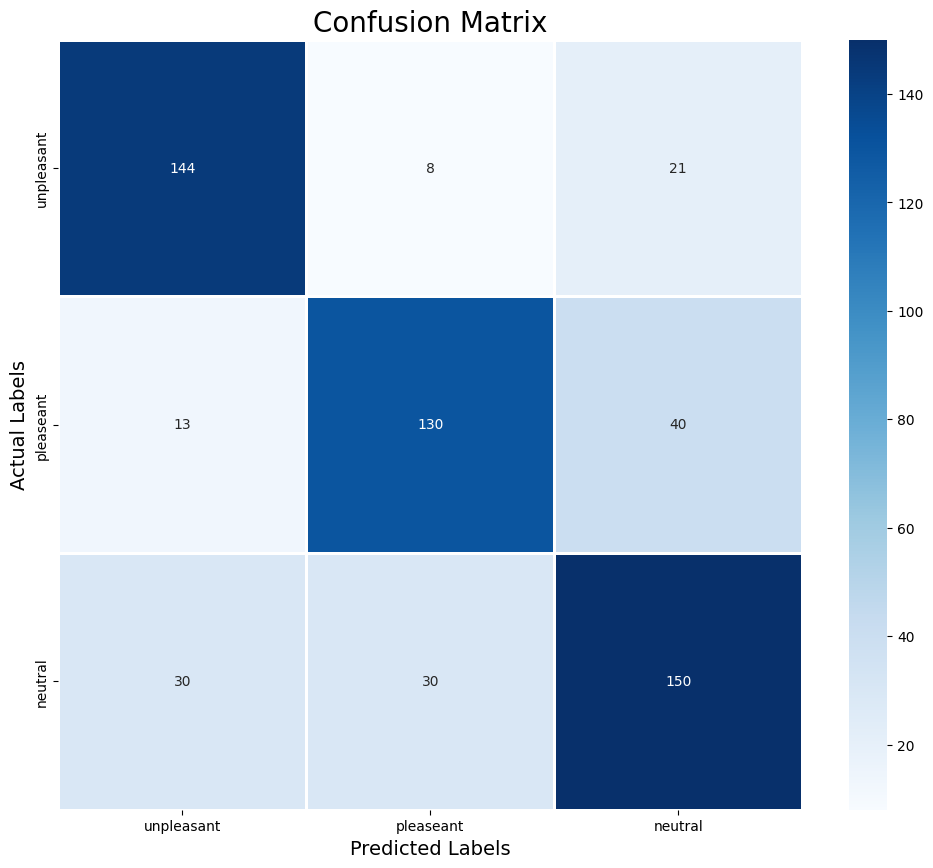

In [37]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = {'unpleasant': 0, 'pleaseant': 1, 'neutral': 2}
label_names = list(labels.keys())
print(classification_report(y_test, y_pred, target_names=label_names))

cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm)

plt.figure(figsize = (12, 10))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

#### 3.2 TinyML Model Conversion & Evaluation
The objective of employing TinyML techniques is to minimize both the model size and inference time, while preserving a comparable level of accuracy. Consequently, we conduct a comparison between the inference time and accuracy of the original TensorFlow model and the TensorFlow Lite model.
In this section, our objects are as follow:
- Convert the model to tf lite model.
- Compare the size and the accuracy of models (before and after compress)
- Save the model in the format that deployable into suitable MCU

In [43]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()
with tf.io.gfile.GFile("/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/SER_quant.tflite", 'wb') as f:
   f.write(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model = converter.convert()
with tf.io.gfile.GFile("/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/SER_quant.tflite", 'wb') as f:
   f.write(quant_tflite_model)

print("Save the Tensorflow 'Lite' model!")

Save the Tensorflow 'Lite' model!


In [44]:
def evaluate_tflite(interpreter, test_data, test_label):
    # Get the input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    num_correct = 0
    num_total = 0

    # Iterate over the testing data.
    for i in range(test_data.shape[0]):
        # Get the input data for this example.
        input_data = np.array([test_data[i]], dtype=np.float32)

        # Set the input tensor.
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference.
        interpreter.invoke()

        # Get the output tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Compute the predicted label.
        predicted_label = np.argmax(output_data)

        # Update the results.
        if predicted_label == test_label[i]:
            num_correct += 1
        num_total += 1

    # Reset all variables so it will not pollute other inferences.
    interpreter.reset_all_variables()

    # Compute the accuracy.
    accuracy = num_correct / num_total

    return accuracy


# Load tflite model.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/SER_quant.tflite")
interpreter.allocate_tensors()
size_tflite = file_size = os.path.getsize('/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/SER_quant.tflite')


tflite_test_acc = evaluate_tflite(interpreter, X_test, y_test)
original_size = os.path.getsize('/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/Speech-Emotion-Recognition-Model.h5')


In [53]:
input_data = np.random.randn(1, 47, 13).astype(np.float32)

start_time = time.time()
for i in range(100):
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], input_data)
    interpreter.invoke()
    tflite_predictions = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
    interpreter.reset_all_variables()
tflite_inference_time = time.time() - start_time

start_time = time.time()
for i in range(100):
    h5_predictions = model.predict(input_data)
h5_inference_time = time.time() - start_time



print("Inference Time Comparison:")
print(f"Original Model: {h5_inference_time}s")
print(f"TF Lite Model: {tflite_inference_time}s")


1/1 [==============================] - 0s 34ms/step
Inference Time Comparison:
Original Model: 16.89073872566223s
TF Lite Model: 0.4133036136627197s


In [54]:
# Define the data for comparison
data = [
    ["Original model",original_size, test_acc*100, h5_inference_time],
    ["lite model", size_tflite, tflite_test_acc * 100, tflite_inference_time],
]

# Define the headers for the table
headers = ["Model", "Size", "Accuracy", "Inteference_time"]

# Create a DataFrame
df = pd.DataFrame(data, columns=headers)

# Print the DataFrame
print(df)

            Model     Size   Accuracy  Inteference_time
0  Original model  1568912  74.911660         16.890739
1      lite model   150032  74.558304          0.413304


Finally, after converting the original model to TensorFlow Lite format, additional steps are required to deploy the model on a microcontroller. Specifically, we need to convert the TFLite file into a TFLite "Micro" file, which can then be uploaded to microcontrollers such as Arduino Nano 33 BLE. This process enables the implementation of real-time SER (Speech Emotion Recognition) applications with accuracy comparable to the original model.

In [50]:
MODEL_TFLITE = '/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/SER_quant.tflite'
MODEL_TFLITE_MICRO = '/content/drive/MyDrive/Colab_Notebooks/kaggle/working/Models/SER_micro.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}
print("Save the Tensorflow Lite 'Micro' model!")


Save the Tensorflow Lite 'Micro' model!
